In [10]:
import torch as t
from transformers import AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt
import time
import numpy as np
import sklearn
import pickle
import re

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import svm
from sklearn.metrics import accuracy_score

In [11]:
def create_dataset(i_start=0, i_end=50, operation=t.add):
    """(1 pt) Create a dataset of pairs of numbers to calculate an operation on.
    DO NOT USE A FOR LOOP. Use pytorch functions, possibilities include meshgrid, stack, reshape, repeat, tile.
    (Note you'll have to use for loops on string stuff in other functions)

    The dataset should be a tuple of two tensors, X and y, where X is a Nx2 tensor of numbers to add,
    and y is a N tensor of the correct answers.
    E.g., if i_start=0, i_end=2, then X should be tensor([[0,0,1,1],[0,1,0,1]]).T and y should be tensor([0,1,1,2]).
    I recommend doing all pairs of sums involving 0-49, but you may modify this.
    """
    # TODO

    first_operand, second_operand = t.meshgrid(t.arange(i_start, i_end), 
                                                t.arange(i_start, i_end))
    first_operand = t.reshape(first_operand, (-1,))
    second_operand = t.reshape(second_operand, (-1,))
    
    X = t.stack([first_operand, second_operand])
    
    if operation == t.add:
        y = first_operand + second_operand
    elif operation == t.mul:
        y = first_operand * second_operand
    
    return X, y

In [12]:
def load_LLM(default="EleutherAI/gpt-neo-2.7B", device='cpu'):
    """(1 pt) Load a pretrained LLM and put on device. Default choice is a large-ish GPT-neo-2.7B model on Huggingface.
    Could also consider the "open GPT" from facebook: "facebook/opt-2.7b", or others
    here: https://huggingface.co/models?pipeline_tag=text-generation
    Explicitly load model and tokenizer, don't use the huggingface "pipeline" which hides details of the model
    (and it also has no batch processing, which we need here)
    """
    # TODO
    tokenizer = AutoTokenizer.from_pretrained(default)
    model = AutoModelForCausalLM.from_pretrained(default).to(device)
    
    return model, tokenizer

In [13]:
def encode_problems(X, prompt_prefix=None, strategy='baseline', operation=t.add):
    """(1 pts) Encode the problems as strings. For example, if X is [[0,0,1,1],[0,1,0,1]],
    then the baseline output should be ["0+0=", "0+1=", "1+0=", "1+1="]"""
    
    if operation==t.add:
        operator = "+"
    elif operation==t.mul:
        operator = "*"
        
    output_strings = []
    if strategy == 'baseline':
        # TODO: encode_string =
        output_strings = [ str(X[0][idx].item()) + operator + str(X[1][idx].item()) + "="  \
                              for idx in range(len(X[0])) ]
    else:
        # TODO: encode_string =
        output_strings = [ prompt_prefix + str(X[0][idx].item()) + operator + str(X[1][idx].item()) + "="  \
                              for idx in range(len(X[0])) ]

    return output_strings

In [14]:
def generate_text(model, tokenizer, prompts, verbose=True, device='cpu'):
    """(3 pts) Complete the prompt using the LLM.
    1. Tokenize the prompts: https://huggingface.co/docs/transformers/preprocessing
        Put data and model on device to speed up computations
        (Note that in real life, you'd use a dataloader to do this efficiently in the background during training.)

    2. Generate text using the model.
        Turn off gradient tracking to save memory.
        Determine the sampling hyper-parameters.
        You may need to do it in batches, depending on memory constraints

    3. Use the tokenizer to decode the output.
    You will need to optionally print out the tokenization of the input and output strings for use in the write-up.
    """
    t0 = time.time()
    pad_token_id = tokenizer.eos_token_id
    # TODO: turn off gradient tracking
    with t.no_grad():
        output_strings = []
        for prompt in prompts:
            # TODO: tokenize
            tokenized_prompt = tokenizer.encode(prompt, return_tensors="pt").to(device)
            max_length = len(tokenized_prompt) + 50
            
            # TODO: generate text
            tokenized_generated_text = model.generate(tokenized_prompt, do_sample=False, temperature=0.0001,
                                                     max_length=max_length, pad_token_id=pad_token_id)
            
            # TODO: decode output, output_strings = ...
            output_strings.append(tokenizer.decode(tokenized_generated_text[0]))
    if verbose:
        # TODO: print example tokenization for write-up
        print()
        
    print("Time to generate text: ", time.time() - t0)  # It took 4 minutes to do 25000 prompts on an NVIDIA 1080Ti.
    return output_strings

In [15]:
import re

def decode_output(output_strings, strategy='baseline', verbose=True):
    """(1 pt) Decode the output strings into a list of integers. Use "t.nan" for failed responses.
    One suggestion is to split on non-numeric characters, then convert to int. And use try/except to catch errors.
    """
    
    non_math_symbol_regex = re.compile(r"[^0-9+\-*/= ]")

    y_hat = []
    for s in output_strings:
        # TODO: y = f(s)
        try:
            split_idx = len(s)
            match = non_math_symbol_regex.search(s)
            if match:
                split_idx = match.start()
            
            y = int(s[:split_idx].strip())
            
        except:
            y = t.nan
        y_hat.append(y)
    return y_hat

In [16]:
def analyze_results(X, y, y_hats, strategies):
    """(3 pts) Analyze the results.
    Output the accuracy of each strategy.
    Plot a scatter plot of the problems “x1+x2” with x1,x2 on each axis,
    and different plot markers to indicate whether the answer from your LLM was correct.
    (See write-up instructions for requirements on plots)
    Train a classifier to predict whether the LLM gave the correct response (using scikit-learn, for example)
    and plot the classifier boundary over the scatter plot with “contour”. (Use whatever classifier looks appropriate)"""
    
    # TODO
    
    # Creating dataframe
    df = pd.DataFrame(
        {'x1': X[0].numpy(),
         'x2': X[1].numpy(),
         'y': y.numpy(),
         'y_hats': y_hats
        })

    # Calculating accuracy
    df['correct/incorrect'] = df.apply(lambda row: 'correct' if row['y'] == row['y_hats'] else 'incorrect', axis=1)
    accuracy = ((df[df['correct/incorrect']=='correct'].shape[0]/df.shape[0]))
    print("Accuracy of the strategy", strategies, ":", round(accuracy, 3), "%")
    
    # Train a classifier on the data
    clf = svm.SVC(kernel='linear')
    clf.fit(df[['x1', 'x2']], df['y'])
    Z = clf.predict(df[['x1', 'x2']])
    print('Accuracy using classifier:', accuracy_score(df['y'], Z))
    
    
    # Creating data points for contours
    # Get the minimum and maximum values of the two features in the training data
    x1_min, x1_max = df['x1'].min() - 1, df['x1'].max() + 1
    x2_min, x2_max = df['x2'].min() - 1, df['x2'].max() + 1

    # Create a 2D grid using these minimum and maximum values with a step size
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max),
                         np.arange(x2_min, x2_max))

    # Use the trained classifier to predict the class labels for each point in the grid
    Z = clf.predict(np.c_[xx1.ravel(), xx2.ravel()])
    Z = Z.reshape(xx1.shape)

    with plt.style.context('seaborn-bright'):
        
        # plot the calculations
        sns.lmplot(x='x1', y='x2', data=df, hue='correct/incorrect', fit_reg=False, legend=False, markers=["1", "x"])
        
        # plot the contour
        plt.contourf(xx1, xx2, Z, alpha=0.2)
        
        plt.legend(loc='best')
        plt.xlabel('x1', fontweight='bold')
        plt.ylabel('x2', fontweight='bold')
        
        if (df['x1'].max()+1 - df['x1'].min()) > 10:
            plt.xticks(np.arange(df['x1'].min(), df['x1'].max()+1, (df['x1'].max()+1 - df['x1'].min())//10), 
                       fontweight='bold')
            plt.yticks(np.arange(df['x2'].min(), df['x2'].max()+1, (df['x2'].max()+1 - df['x2'].min())//10), 
                       fontweight='bold')
        else:
            plt.xticks(np.arange(df['x1'].min(), df['x1'].max()+1, 1), 
                       fontweight='bold')
            plt.yticks(np.arange(df['x2'].min(), df['x2'].max()+1, 1), 
                       fontweight='bold')
            
        plt.title(strategies, fontsize=22)
        plt.savefig(strategies+'.png', bbox_inches='tight')

Current run for: baseline

Time to generate text:  654.0818054676056
Accuracy of the strategy baseline : 0.4 %
Accuracy using classifier: 0.84


/media/masud/5dec78b5-09e8-44c9-86f0-cc0f1a7bbc35/temp_dir/llama/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(




Current run for: new

Time to generate text:  458.7597439289093
Accuracy of the strategy new : 0.88 %
Accuracy using classifier: 0.84


/media/masud/5dec78b5-09e8-44c9-86f0-cc0f1a7bbc35/temp_dir/llama/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


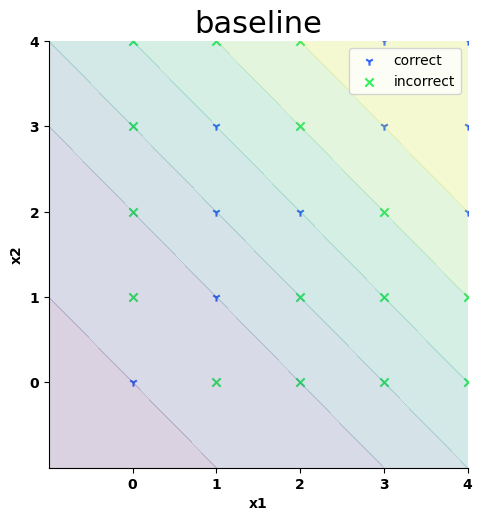

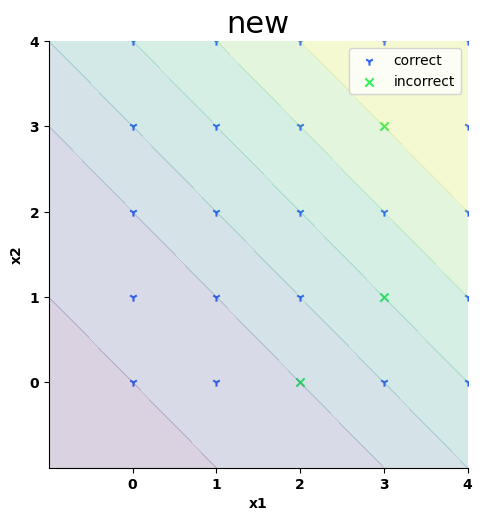

In [18]:
if __name__ == "__main__":
    
    device = t.device("cuda" if t.cuda.is_available() else "cpu")  # Use GPU if available
    device = t.device('mps') if t.backends.mps.is_available() else device  # Use Apple's Metal backend if available

    operation = t.add
    X, y = create_dataset(0,5, operation)
    model, tokenizer = load_LLM(device=device)
    
    y_hats = []  # list of lists of predicted answers, y_hat, for each strategy
    strategies = ['baseline', 'new']
    
    for strategy in strategies:
        
        print("Current run for:", strategy)
        if strategy == 'baseline':
            prompt_prefix = None
        else:
            if operation == t.add:
                prompt_prefix = "You are a calculator. Please calculate: 1+2=3, 3+4=7, 11+32=43,"
            elif operation == t.mul:
                prompt_prefix = "You are a calculator. Please calculate: 1*2=2, 3*4=12, 11*12=132,"
                
        input_strings = encode_problems(X, strategy=strategy, prompt_prefix=prompt_prefix, operation=operation)
        output_strings = generate_text(model, tokenizer, input_strings, device=device)
        
#         print(input_strings)
#         print(output_strings)
        
        output_strings = [out_s[len(in_s):] for in_s, out_s in zip(input_strings, output_strings)]  # Remove the input string from generated answer
        y_hats = (decode_output(output_strings, strategy=strategy))
        
        
        analyze_results(X, y, y_hats, strategy)
        
        print()
        print()